In [1]:
from temp.gamap_colormap import WhGrYlRd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xbpch

import warnings

warnings.filterwarnings("ignore")  # hide some xbpch warnings

In [2]:
# Files path
ARGS = {
    "trac_bpch": "temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000",
    "trac_nc": "temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000.nc",
    "tracerinfo": "temp/geos45s/tracerinfo.dat",
    "diaginfo": "temp/geos45s/diaginfo.dat",
    "fw_out": lambda x, l: f"out/img/{x}_cartopy_lev_{l}.png",
    "f_out": lambda x, l: f"out/img/{x}_lev_{l}.png",
}

In [3]:
# Get value size array
def rlen(variable):
    return range(len(variable))

In [4]:
# Open binary diagnostic with .dat (contain tracer names and other metadata)
df_trac = xbpch.open_bpchdataset(
    ARGS["trac_bpch"],
    tracerinfo_file=ARGS["tracerinfo"],
    diaginfo_file=ARGS["diaginfo"],
)
df_trac

<xarray.Dataset>
Dimensions:            (lat: 46, lev: 72, lev_edge: 73, lon: 72, nv: 2, time: 2)
Coordinates:
  * lev                (lev) float64 0.9925 0.9775 ... 1.614e-05 4.935e-06
  * lon                (lon) float64 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * lat                (lat) float64 -89.0 -86.0 -82.0 -78.0 ... 82.0 86.0 89.0
  * time               (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv                 (nv) int64 0 1
Dimensions without coordinates: lev_edge
Data variables:
    PL_SUL_S_SO2dms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    time_bnds          (time, nv) datetime64[ns] 2015-01-01 ... 2015-03-01
    PL_SUL_S_SO2no3    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_SO2tot    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_MSAdms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), me

In [5]:
# Select variable
df_trac["IJ_AVG_S_CO"]

<xarray.DataArray 'IJ_AVG_S_CO' (time: 2, lon: 72, lat: 46, lev: 72)>
dask.array<mul, shape=(2, 72, 46, 72), dtype=float32, chunksize=(1, 72, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9624 ... 1.614e-05 4.935e-06
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
Attributes:
    number:          4
    category:        IJ-AVG-$
    name:            CO
    full_name:       CO tracer
    molwt:           0.028
    C:               1
    tracer:          4
    hydrocarbon:     False
    chemical:        True
    original_shape:  (72, 46, 72)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

In [6]:
# Select time boundaries
df_trac["time_bnds"]

<xarray.DataArray 'time_bnds' (time: 2, nv: 2)>
array([['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000'],
       ['2015-02-01T00:00:00.000000000', '2015-03-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv       (nv) int64 0 1
Attributes:
    units:    hours since 1985-01-01 00:00:00

In [7]:
# Drop time boundaries and redudant dimension
df_trac = df_trac.drop("time_bnds")
df_trac = df_trac.drop("nv")

In [8]:
# Changes order (time, lon, lat, lev) to common order (time, lev, lat, lon)
# df_trac = df_trac.transpose("time", "lev", "lat", "lon")
# df_trac

In [9]:
# Convert BPCH data to NC format
# df_trac = xbpch.common.fix_attr_encoding(df_trac)
# df_trac.to_netcdf(ARGS["trac_nc"])

In [10]:
# Terminal command
# !ncdump -h temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000.nc

In [11]:
# Open NC
# ds_nc = xr.open_dataset("trac.nc")
# ds_nc

In [12]:
# PM, NOx, NMVOCs
# Get emissions and times
tracers = ["IJ_AVG_S_O3", "IJ_AVG_S_NO2", "IJ_AVG_S_SO2", "IJ_AVG_S_NH3"]
emissions = df_trac[tracers]
times = [t.values.astype("datetime64[M]") for t in emissions["time"]]

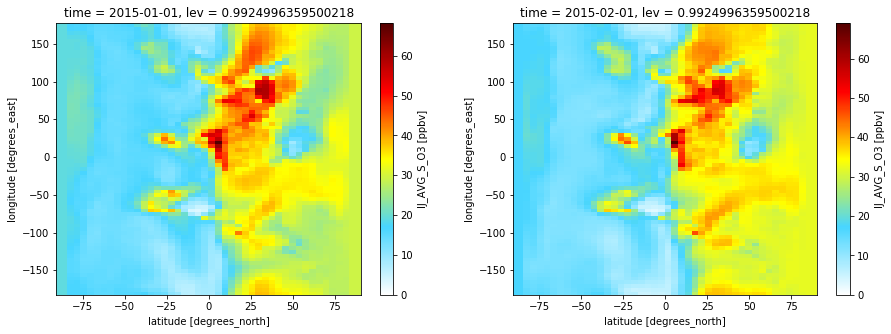

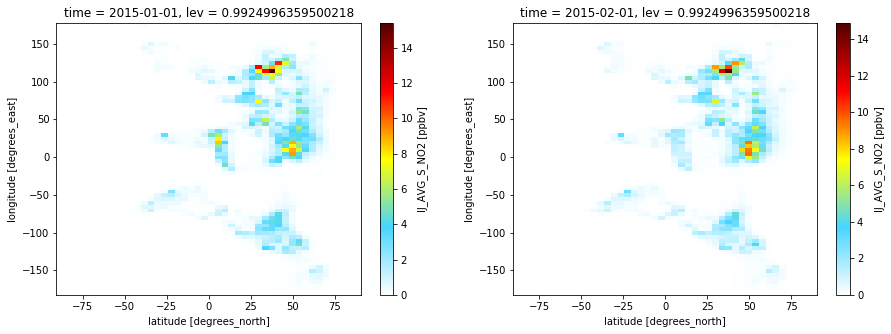

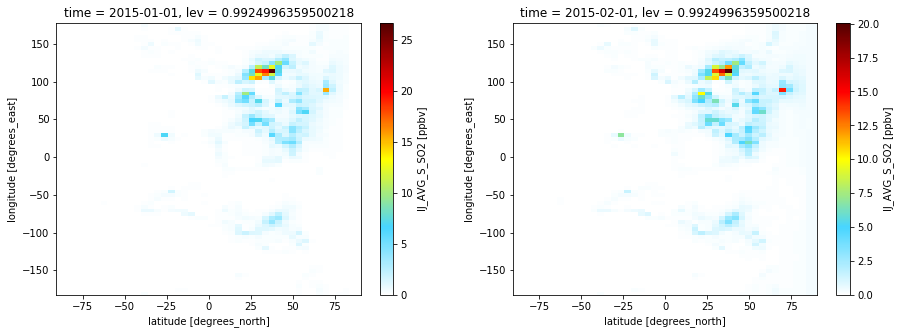

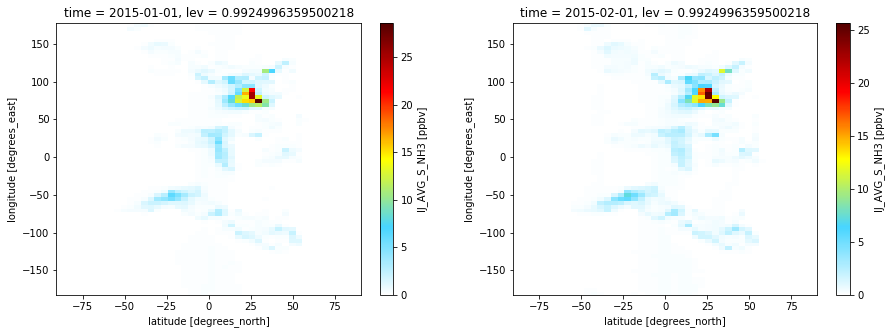

In [13]:
# Plot without cartography
for emission in emissions.values():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot BPCH diagnotics for each time
    for ax, t in zip(axes, rlen(times)):
        emission.isel(time=t, lev=0).plot(ax=ax, cmap=WhGrYlRd, vmin=0)

    plt.savefig(ARGS["f_out"](emission.attrs["name"], 0))

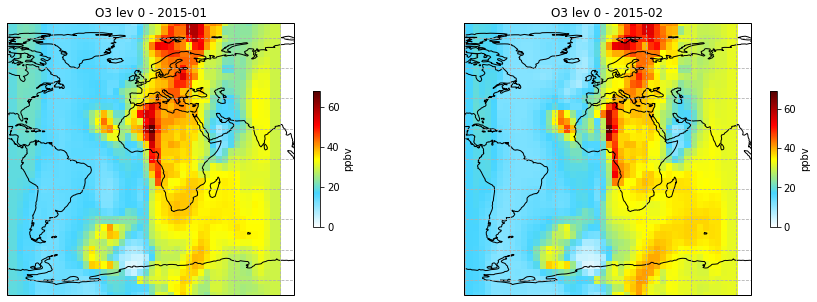

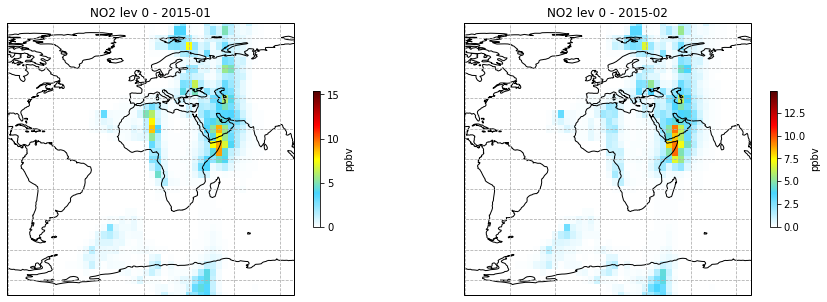

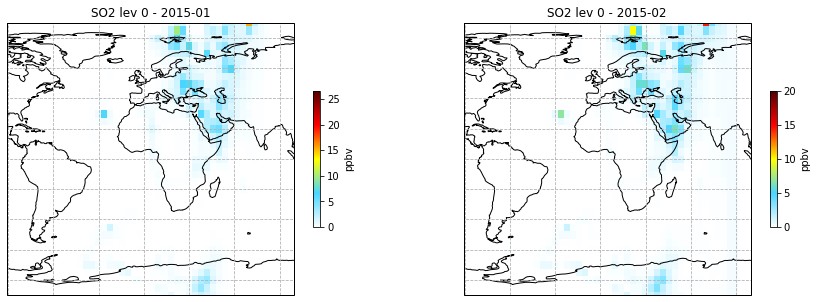

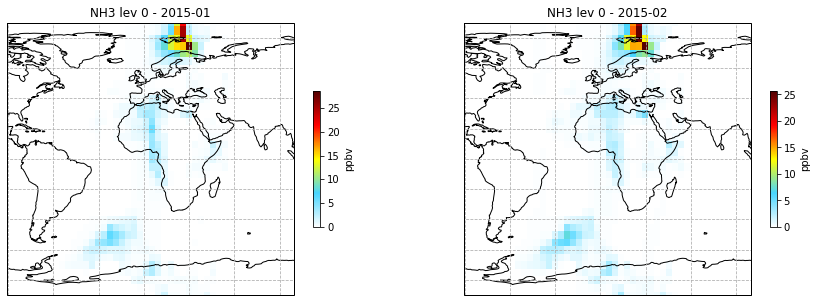

In [14]:
# Plot with cartography
for emission in emissions.values():
    fig, axes = plt.subplots(
        1, 2, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # Plot BPCH diagnotics for each time
    for ax, t in zip(axes, rlen(times)):
        emission.isel(time=t, lev=0).plot(
            ax=ax,
            cmap=WhGrYlRd,
            vmin=0,
            cbar_kwargs={"shrink": 0.5, "label": "ppbv"},
        )
        ax.set_title(f"{emission.attrs['name']} lev 0 - {times[t]}")
        ax.coastlines()
        ax.gridlines(linestyle="--")

    plt.savefig(ARGS["fw_out"](emission.attrs["name"], 0))